# Introduction

In computer vision, the most common goal is to classify an image (“cat”, “dog”, “car”, etc.). But in many cases, we are more interested in **comparing** images with each other: finding similar examples, grouping content, or measuring visual proximity. For this, we want to learn a representation space (*embedding*) in which similar images are close and different images are far apart.

In the first part of this series of articles, we will train a Siamese network with a *triplet loss* on CIFAR‑10.

We will then study the KoLeo loss, a batch-dependent regularization that aims to better distribute the embeddings. This dependency naturally raises the question of gradient accumulation (effective batch size): what impact does it have on training and the quality of embeddings?

We start by describing the dataset, the construction of triplets, and the evaluation, then we will compare the results with and without *KoLeo* before discussing the effect of gradient accumulation.

First, we set the *seeds* for reproducibility.

In [50]:
import numpy as np
import torch

seed = 42

def set_seed(seed):
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
    if torch.mps.is_available():
        torch.mps.manual_seed(seed)

set_seed(seed)


## The Dataset Used

To train and evaluate our model, we use the [CIFAR‑10](https://www.cs.toronto.edu/~kriz/cifar.html) dataset, a classic *benchmark* composed of 60,000 color images (32×32 pixels) divided into 10 balanced classes: airplane, car, bird, cat, deer, dog, frog, horse, ship, and truck. The dataset is initially separated into 50,000 training examples and 10,000 test examples, but here we only use the training data.

After downloading, we notice that the archive contains 6 binary files: `data_batch_1` to `data_batch_5` and `test_batch`. We will only use the `data_batch_*` files.


In [51]:
import pickle

def unpickle(file):
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding='bytes')
    return dict

data_batch = [unpickle(f"../../../cifar-10-python/data_batch_{i}") for i in range(1, 6)]
images = np.concatenate([data_batch[i][b'data'] for i in range(5)])
labels = np.concatenate([data_batch[i][b'labels'] for i in range(5)])

images = images.reshape((-1, 3, 32, 32)).transpose(0, 2, 3, 1)
images.shape


(50000, 32, 32, 3)

We therefore have 50,000 images of size 32×32 in RGB. Here are a few selected randomly, with their class.


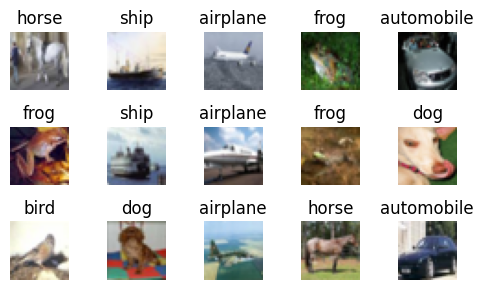

In [52]:
import matplotlib.pyplot as plt

label_names = ['airplane', 'automobile', 'bird', 'cat', 'deer',
               'dog', 'frog', 'horse', 'ship', 'truck']

n_rows, n_cols = 3, 5
indices = np.random.choice(len(images), n_rows * n_cols, replace=False)

fig, axes = plt.subplots(n_rows, n_cols, figsize=(n_cols, n_rows))

for ax, idx in zip(axes.ravel(), indices):
    ax.imshow(images[idx])
    label = label_names[labels[idx]]
    ax.set_title(label)
    ax.axis("off")

plt.tight_layout()
plt.show()


# Siamese Networks

## What is a Siamese Network?

A Siamese network is a neural network architecture designed not to directly predict a class, but to **compare** examples with each other.

The key idea is this: two images that we consider “similar” (for example, two dogs) must be close in the representation space, while two “different” images (a dog and a car) must be far apart. During training, we therefore present the model with pairs or triplets of images (`anchor`, `positive`, `negative`) and we adjust the weights to bring `anchor` and `positive` closer, while moving `anchor` and `negative` further apart.


![Siamese network scheme](../images/siamese-scheme-english.png)

In the following, we will detail the model used to produce these embeddings as well as the cost function (the *triplet loss*) which formalizes this notion of similarity.

## VGG11

VGG11 is a convolutional neural network architecture proposed in 2014 by a team from the University of Oxford (Simonyan and Zisserman). The major idea of the VGG network family is to stack many small 3×3 convolutional filters, separated by *pooling* layers, rather than using a few large convolutions. This allows increasing the depth of the network while keeping a very regular structure. We will start from this architecture pre-trained on ImageNet and adapt it to produce embeddings.

![VGG11](../images/vgg11-model.png)

Let's first see the size of the tensor at the output of VGG11.


In [54]:
from torchvision import models

vgg = models.vgg11(weights=None)

sample = images[0]                              
x = torch.from_numpy(sample).permute(2, 0, 1)
x = x.unsqueeze(0).float() / 255.0

with torch.no_grad():
    out = vgg(x)

print("Size of the tensor after VGG11:", out.shape)


Size of the tensor after VGG11: torch.Size([1, 1000])


The size `(1, 1000)` means that, for an input image, VGG11 returns a vector of 1,000 components. This number comes directly from the final linear layer of the original model (`FC-1000` then `Softmax` on the diagram): VGG11 was designed to assign a class among 1000 to each image. Its last layer therefore produces a vector of 1,000 scores containing the probabilities of belonging for all classes.

In our case, we will not use this vector. We will use the output of the last convolutional layer, accessible via `vgg.features`.

What is the size of the tensor just after the last convolutional layer?


In [55]:
with torch.no_grad():
    out = vgg.features(x)

print("Size of the tensor after the last convolutional layer:", out.shape)


Size of the tensor after the last convolutional layer: torch.Size([1, 512, 1, 1])


We obtain a tensor of shape `(512, 1, 1)`.

- `512` corresponds to the number of feature maps produced by the last convolutional layer: 512 channels describing the image.
- `(1, 1)` corresponds to the spatial dimensions, reduced to 1×1 by the succession of convolutions and pooling. Each channel therefore summarizes the image into a single value before passing to the fully connected layers.

The input of the linear layer therefore has a dimension \(512 x 1 x 1 = 512\). To obtain a more compact embedding vector, we then project to dimension 128 via a linear layer. Finally, we add a normalization layer at the output, useful for comparisons between embeddings.


In [59]:
import torch.nn as nn
import torch.nn.functional as F

class VGG11Embedding(nn.Module):
    def __init__(self, weights):
        super(VGG11Embedding, self).__init__()
        vgg = models.vgg11(weights=weights)
        self.features = vgg.features
        self.linear = nn.Linear(512, 128)
        
    def forward(self, x):
        x = self.features(x)
        x = torch.flatten(x, 1)
        x = self.linear(x)
        x = F.normalize(x, p=2, dim=1)
        return x


Let's check the output size of our model:


In [60]:
vgg_embedding = VGG11Embedding(weights=None)

with torch.no_grad():
    out = vgg_embedding(x)

print("Tensor size after our model:", out.shape)


Tensor size after our model: torch.Size([1, 128])


We therefore have an embedding of size 128.

## The *Triplet Loss*

The objective of the *triplet loss* is to impose a geometric structure on the embedding space: for each triplet of images (`anchor`, `positive`, `negative`), we want the embedding of `positive` to be closer to that of `anchor` than that of `negative`, with a certain margin. In other words, we seek to verify
$$ d(f(a), f(p)) + m < d(f(a), f(n)) $$
where \\(f(\cdot)\\) is the embedding network, \\(d\\) a distance measure and \\(m > 0\\) the margin.


In our case, we use a distance derived from cosine similarity: the closer two vectors are angularly, the more they are considered similar. The *triplet loss* is then written, for a batch of size \\(B\\),
$$ \mathcal{L} = \frac{1}{B} \sum_{i=1}^B \max\big(0,\ d(-i, p_i) - d(-i, n_i) + m\big). $$

Each term is zero as soon as the constraint is satisfied (the triplet is “good”). The value is strictly positive when `anchor` is still too close to `negative`. We therefore do not only want \\(d(-i, p_i) < d(-i, n_i)\\), but a separation of at least \\(m\\).


In [61]:
def triplet_loss(anchor, positive, negative, margin=0.4):
    positive_distances = 1 - F.cosine_similarity(anchor, positive, dim=1)
    negative_distances = 1 - F.cosine_similarity(anchor, negative, dim=1)
    loss = torch.clamp(positive_distances - negative_distances + margin, min=0)
    return loss.mean()


## Construction of Triplets

To train a Siamese network with a *triplet loss*, we must transform our dataset of independent images into a dataset of triplets (`anchor`, `positive`, `negative`). On CIFAR‑10, we proceed class by class:
- for a given class (for example “cat”), we form pairs (`anchor`, `positive`) with two images of this class;
- we then randomly draw an image from a different class to play the role of `negative`.

We repeat this operation for each of the 10 classes, which gives a globally balanced set of triplets. The code below constructs these triplets from the `images` and `labels` arrays, and we sample the number of `negative` images to 2,500.


In [62]:
triplets = np.empty((0, 3, 32, 32, 3), dtype=np.uint8)
triplets_labels = np.empty((0, 3), dtype=np.uint8)

set_seed(seed)
for target in range(10):
    class_mask = (labels == target)
    images_target = images[class_mask]
    labels_target = labels[class_mask]

    pairs = images_target.reshape(-1, 2, 32, 32, 3)
    pos_labels = np.ones((len(pairs), 2), dtype=np.uint8) * target

    not_target_mask = (labels != target)
    images_not_target = images[not_target_mask]
    labels_not_target = labels[not_target_mask]

    # On echantillonne un nombre fixe de negatives pour cette classe
    n_neg = min(2500, len(images_not_target))
    neg_indices = np.random.choice(len(images_not_target), n_neg, replace=False)
    negatives = images_not_target[neg_indices]
    neg_labels = labels_not_target[neg_indices]

    pairs = pairs[:n_neg]
    pos_labels = pos_labels[:n_neg]

    class_triplets = np.concatenate(
        [pairs, negatives.reshape(n_neg, 1, 32, 32, 3)],
        axis=1,
    )
    class_triplet_labels = np.concatenate(
        [pos_labels, neg_labels.reshape(n_neg, 1)],
        axis=1,
    )

    triplets = np.concatenate([triplets, class_triplets], axis=0)
    triplets_labels = np.concatenate([triplets_labels, class_triplet_labels], axis=0)

triplets.shape, triplets_labels.shape


((25000, 3, 32, 32, 3), (25000, 3))

### The `TripletsCIFAR10Dataset` Class and Triplet Visualization

To facilitate training, we encapsulate these triplets in a dedicated `Dataset`. The tensor of triplets is converted to the format `(N, 3, C, H, W)` then, at each call, the three images (`anchor`, `positive`, `negative`) are returned.


In [63]:
from torch.utils.data import Dataset
import torchvision.transforms as T

class TripletsCIFAR10Dataset(Dataset):
    def __init__(self, triplets, transform=None):
        # (N, 3, H, W, C) -> (N, 3, C, H, W)
        self.triplets = torch.from_numpy(
            triplets.transpose(0, 1, 4, 2, 3) / 255.0
        ).float()
        self.transform = transform

    def __len__(self):
        return self.triplets.shape[0]

    def __getitem__(self, idx):
        triplet = self.triplets[idx]
        anchor, positive, negative = triplet[0], triplet[1], triplet[2]
        if self.transform is not None:
            anchor = self.transform(anchor)
            positive = self.transform(positive)
            negative = self.transform(negative)
        return anchor, positive, negative

train_transforms = T.Compose([
    T.RandomCrop(32, padding=4),
    T.RandomHorizontalFlip(),
    T.Normalize(mean=[0.4914, 0.4822, 0.4465], std=[0.2470, 0.2435, 0.2616]),
])

val_transforms = T.Compose([
    T.Normalize(mean=[0.4914, 0.4822, 0.4465], std=[0.2470, 0.2435, 0.2616]),
])

triplet_dataset = TripletsCIFAR10Dataset(triplets)


Let's visualize a random selection of triplets.


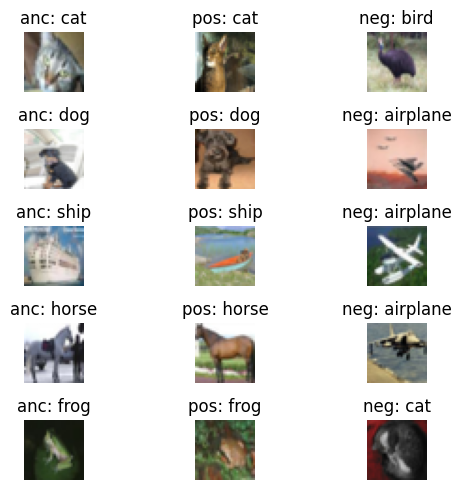

In [64]:
n_examples = 5
indices = np.random.choice(len(triplet_dataset), n_examples, replace=False)

fig, axes = plt.subplots(n_examples, 3, figsize=(6, 1 * n_examples))

for row_idx, idx in enumerate(indices):
    anchor, positive, negative = triplet_dataset[idx]

    anchor_img = anchor.permute(1, 2, 0).numpy()
    positive_img = positive.permute(1, 2, 0).numpy()
    negative_img = negative.permute(1, 2, 0).numpy()

    anchor_label = int(triplets_labels[idx, 0])
    positive_label = int(triplets_labels[idx, 1])
    negative_label = int(triplets_labels[idx, 2])

    axes[row_idx, 0].imshow(anchor_img)
    axes[row_idx, 0].set_title(f'anc: {label_names[anchor_label]}', fontsize=12)
    axes[row_idx, 0].axis('off')
    axes[row_idx, 0].set_ylabel(f'Triplet {idx}', fontsize=12, rotation=0, labelpad=50)

    axes[row_idx, 1].imshow(positive_img)
    axes[row_idx, 1].set_title(f'pos: {label_names[positive_label]}', fontsize=12)
    axes[row_idx, 1].axis('off')

    axes[row_idx, 2].imshow(negative_img)
    axes[row_idx, 2].set_title(f'neg: {label_names[negative_label]}', fontsize=12)
    axes[row_idx, 2].axis('off')

plt.tight_layout()
plt.show()


## Training

### Training Parameters

To train our Siamese network with the *triplet loss*, we must choose a few key hyperparameters:
- the **batch size**;
- the **learning rate** of the optimizer;
- the **number of epochs**;
- the **margin** of the *triplet loss*.

We also define the `device` and choose Adam as the optimizer.


In [ ]:
from torchvision.models import VGG11_Weights

if torch.cuda.is_available():
    device = "cuda"
elif hasattr(torch.backends, "mps") and torch.backends.mps.is_available():
    device = "mps"
else:
    device = "cpu"

batch_size = 64
learning_rate = 5e-4
margin = 0.4

net = VGG11Embedding(weights=VGG11_Weights.IMAGENET1K_V1).to(device)
optimizer = torch.optim.Adam(net.parameters(), lr=learning_rate)


### Evaluation Metrics

We use the following metrics to evaluate the model on the validation phase:
- **ratio of “good” triplets**: proportion of triplets where `anchor` is closer to `positive` than to `negative`;
- **mean cosine similarities** `anchor`–`positive` and `anchor`–`negative`;
- **mean Euclidean distances** `anchor`–`positive` and `anchor`–`negative`;
- **AUC**.

#### AUC (*Area Under the Curve*)

The AUC is the area under the ROC curve (*Receiver Operating Characteristic*), which plots the true positive rate as a function of the false positive rate for all possible thresholds. It measures the model's ability to correctly order the examples: concretely, it is the probability that a positive example receives a higher similarity than a negative example. An AUC of 0.5 corresponds to a random classification, while an AUC of 1 indicates a perfect separation.

In our context, the network produces embeddings (and not class probabilities). To calculate the AUC, we reduce to a binary pair-to-pair task: we consider (`anchor`, `positive`) as a positive pair (label 1) and (`anchor`, `negative`) as a negative pair (label 0). The cosine similarity between embeddings serves as a score, and the AUC summarizes how well the model assigns higher similarities to pairs of the same class.

### Training Loop

The training loop iterates through the `DataLoader` of triplets, calculates the embeddings `(f(a), f(p), f(n))` for each batch, evaluates the *triplet loss*, then performs a backpropagation step and weight update. We also calculate the average *loss* per epoch and periodically display the current *loss* to track convergence.


In [15]:
def train_loop(net, dataloader, optimizer, margin, print_freq=10):
    net.train()
    loss_accum = 0.0
    epoch_loss = 0.0
    for batch_idx, (anc, pos, neg) in enumerate(dataloader):
        anc, pos, neg = anc.to(device), pos.to(device), neg.to(device)
        anc_feat, pos_feat, neg_feat = net(anc), net(pos), net(neg)

        loss = triplet_loss(anc_feat, pos_feat, neg_feat, margin)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        loss_accum += loss.item()
        epoch_loss += loss.item()

        if (batch_idx + 1) % print_freq == 0:
            print(f"Batch {batch_idx+1} : loss = {loss_accum / print_freq:.4f}")
            loss_accum = 0.0

    return epoch_loss / (batch_idx + 1)


### Validation Loop

For the entire validation set, we calculate the metrics defined above (cosine similarities, Euclidean distances, ratio of good triplets and AUC).


In [16]:
from sklearn.metrics import roc_auc_score

def validation_loop(net, dataloader, margin):
    net.eval()
    val_loss = 0.0
    good_triplets = 0
    total_triplets = 0

    positive_similarities = []
    negative_similarities = []
    positive_euclidean_distances = []
    negative_euclidean_distances = []

    with torch.no_grad():
        for batch_idx, (anc, pos, neg) in enumerate(dataloader):
            anc, pos, neg = anc.to(device), pos.to(device), neg.to(device)
            anc_feat, pos_feat, neg_feat = net(anc), net(pos), net(neg)

            loss = triplet_loss(anc_feat, pos_feat, neg_feat, margin)
            val_loss += loss.item()

            batch_pos_euc = F.pairwise_distance(anc_feat, pos_feat, p=2)
            batch_neg_euc = F.pairwise_distance(anc_feat, neg_feat, p=2)
            positive_euclidean_distances.append(batch_pos_euc)
            negative_euclidean_distances.append(batch_neg_euc)

            batch_pos_sim = F.cosine_similarity(anc_feat, pos_feat, dim=1)
            batch_neg_sim = F.cosine_similarity(anc_feat, neg_feat, dim=1)
            positive_similarities.append(batch_pos_sim)
            negative_similarities.append(batch_neg_sim)

            good_triplets += (batch_pos_sim > batch_neg_sim).sum()
            total_triplets += anc.shape[0]

    positive_euclidean_distances = torch.cat(positive_euclidean_distances, dim=0)
    negative_euclidean_distances = torch.cat(negative_euclidean_distances, dim=0)
    positive_similarities = torch.cat(positive_similarities, dim=0)
    negative_similarities = torch.cat(negative_similarities, dim=0)

    scores = torch.cat([positive_similarities, negative_similarities], dim=0)
    targets = torch.cat([
        torch.ones_like(positive_similarities),
        torch.zeros_like(negative_similarities)
    ], dim=0)

    val_auc = roc_auc_score(targets.cpu().numpy(), scores.cpu().numpy())

    return {
        "val_loss": val_loss / (batch_idx + 1),
        "val_auc": val_auc,
        "mean_positive_similarities": positive_similarities.mean().item(),
        "mean_negative_similarities": negative_similarities.mean().item(),
        "mean_positive_euclidean_distances": positive_euclidean_distances.mean().item(),
        "mean_negative_euclidean_distances": negative_euclidean_distances.mean().item(),
        "good_triplets_ratio": (good_triplets / total_triplets).item(),
    }


### Complete Training over Several Epochs

To train a model, we need to construct our training and validation `DataLoader`s:


In [17]:
from torch.utils.data import DataLoader

val_split = 0.05
num_train = int((1 - val_split) * len(triplets))

shuffle_indices = np.random.permutation(len(triplets))
triplets = triplets[shuffle_indices]
triplets_labels = triplets_labels[shuffle_indices]

train_triplets = triplets[:num_train, ...]
val_triplets = triplets[num_train:]
train_labels = triplets_labels[:num_train, ...]
val_labels = triplets_labels[num_train:]

train_dataset = TripletsCIFAR10Dataset(train_triplets, transform=train_transforms)
val_dataset = TripletsCIFAR10Dataset(val_triplets, transform=val_transforms)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)


We can now write the complete training loop: at each epoch, we train the model on the training triplets, then we calculate the metrics on the validation.

To facilitate experiments, we regularly save the weights. We also save the configuration and validation metrics in the current experiment folder.


In [18]:
from datetime import datetime
import json
from pathlib import Path

runs_dir = Path('runs')
runs_dir.mkdir(exist_ok=True)

timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
save_dir = runs_dir / timestamp
save_dir.mkdir(exist_ok=True)

epochs = 15
save_ckpt_freq = 1

with (save_dir / "config.json").open("w") as fp:
    json.dump({
        "seed": seed,
        "batch_size": batch_size,
        "learning_rate": learning_rate,
        "epochs": epochs,
        "margin": margin,
        "val_split": val_split,
        "num_train": num_train,
        "save_ckpt_freq": save_ckpt_freq
    }, fp, indent=4)


In [20]:
import csv

metrics_path = save_dir / "training_metrics.csv"

train_losses = []
val_losses = []
best_auc = 0
best_epoch_path = None

csv_headers = [
    "epoch",
    "train_loss",
    "val_loss",
    "val_auc",
    "mean_positive_similarities",
    "mean_negative_similarities",
    "mean_positive_euclidean_distances",
    "mean_negative_euclidean_distances",
    "good_triplets_ratio"
]

with open(metrics_path, mode='w', newline='') as csvfile:
    writer = csv.DictWriter(csvfile, fieldnames=csv_headers)
    writer.writeheader()

set_seed(seed)

val_metrics = validation_loop(net, val_loader, margin)
print(f"Before training, epoch 0 — val_loss = {val_metrics['val_loss']}")
print(
    f"Validation metrics — "
    f"val_loss: {val_metrics['val_loss']:.4f}, "
    f"val_auc: {val_metrics['val_auc']:.4f}, "
    f"mean_positive_similarities: {val_metrics['mean_positive_similarities']:.4f}, "
    f"mean_negative_similarities: {val_metrics['mean_negative_similarities']:.4f}, "
    f"mean_positive_euclidean_distances: {val_metrics['mean_positive_euclidean_distances']:.4f}, "
    f"mean_negative_euclidean_distances: {val_metrics['mean_negative_euclidean_distances']:.4f}, "
    f"good_triplets_ratio: {val_metrics['good_triplets_ratio']:.4f}"
)
with open(metrics_path, mode='a', newline='') as csvfile:
    writer = csv.DictWriter(csvfile, fieldnames=csv_headers)
    writer.writerow({
        "epoch": 0,
        "train_loss": "",  # No train_loss before training
        "val_loss": val_metrics['val_loss'],
        "val_auc": val_metrics['val_auc'],
        "mean_positive_similarities": val_metrics['mean_positive_similarities'],
        "mean_negative_similarities": val_metrics['mean_negative_similarities'],
        "mean_positive_euclidean_distances": val_metrics['mean_positive_euclidean_distances'],
        "mean_negative_euclidean_distances": val_metrics['mean_negative_euclidean_distances'],
        "good_triplets_ratio": val_metrics['good_triplets_ratio']
    })

for epoch_idx in range(epochs):
    train_loss = train_loop(net, train_loader, optimizer, margin, print_freq=100)
    val_metrics = validation_loop(net, val_loader, margin)
    val_losses.append(val_metrics['val_loss'])
    train_losses.append(train_loss if epoch_idx > 0 else val_metrics['val_loss'])

    print(
        f"Epoch {epoch_idx+1} — "
        f"train_loss = {train_loss:.4f}, "
        f"val_loss = {val_metrics['val_loss']:.4f}"
    )
    print(
        f"Validation metrics — "
        f"val_loss: {val_metrics['val_loss']:.4f}, "
        f"val_auc: {val_metrics['val_auc']:.4f}, "
        f"mean_positive_similarities: {val_metrics['mean_positive_similarities']:.4f}, "
        f"mean_negative_similarities: {val_metrics['mean_negative_similarities']:.4f}, "
        f"mean_positive_euclidean_distances: {val_metrics['mean_positive_euclidean_distances']:.4f}, "
        f"mean_negative_euclidean_distances: {val_metrics['mean_negative_euclidean_distances']:.4f}, "
        f"good_triplets_ratio: {val_metrics['good_triplets_ratio']:.4f}"
    )

    with open(metrics_path, mode='a', newline='') as csvfile:
        writer = csv.DictWriter(csvfile, fieldnames=csv_headers)
        writer.writerow({
            "epoch": epoch_idx + 1,
            "train_loss": train_loss,
            "val_loss": val_metrics['val_loss'],
            "val_auc": val_metrics['val_auc'],
            "mean_positive_similarities": val_metrics['mean_positive_similarities'],
            "mean_negative_similarities": val_metrics['mean_negative_similarities'],
            "mean_positive_euclidean_distances": val_metrics['mean_positive_euclidean_distances'],
            "mean_negative_euclidean_distances": val_metrics['mean_negative_euclidean_distances'],
            "good_triplets_ratio": val_metrics['good_triplets_ratio']
        })

    if val_metrics['val_auc'] > best_auc:
        best_auc = val_metrics['val_auc']
        if best_epoch_path is not None:
            best_epoch_path.unlink()
        best_epoch_path = save_dir / f'best_epoch_{epoch_idx+1}.pth'
        torch.save(net.state_dict(), best_epoch_path)
        print(f"New best AUC: {best_auc:.4f} (epoch {epoch_idx+1})")

    if (epoch_idx+1) % save_ckpt_freq == 0:
        torch.save(net.state_dict(), save_dir / f'epoch_{epoch_idx+1}.pth')


Before training, epoch 0 — val_loss = 0.0599974462762475
Validation metrics — val_loss: 0.0600, val_auc: 0.9469, mean_positive_similarities: 0.7675, mean_negative_similarities: -0.0421, mean_positive_euclidean_distances: 0.5642, mean_negative_euclidean_distances: 1.4154, good_triplets_ratio: 0.9440


KeyboardInterrupt: 

### Visualization of the Training Loss Curve

Let's plot the evolution of the loss during training. We plot the training loss and the validation loss.


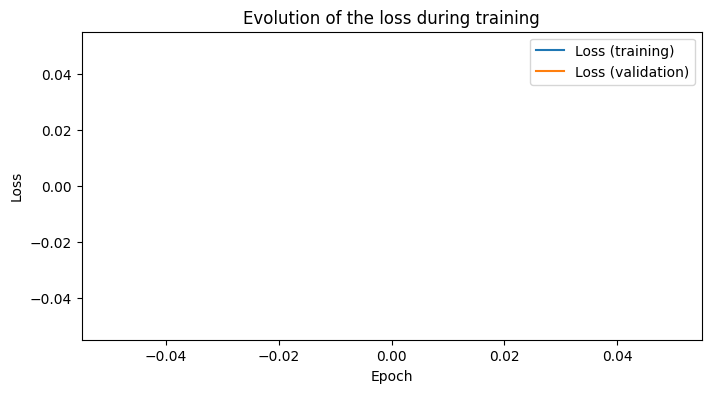

In [21]:
plt.figure(figsize=(8, 4))
plt.plot(train_losses, label="Loss (training)")
plt.plot(val_losses, label="Loss (validation)")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.title("Evolution of the loss during training")
plt.show()


### Visualization of the ROC Curve and AUC

To better interpret the model's performance, we plot the ROC (*Receiver Operating Characteristic*) curve, which represents the true positive rate against the false positive rate for all possible thresholds. The area under this curve (AUC) summarizes in a single number the model's ability to separate pairs of the same class from pairs of different classes.

We use the validation data to construct this curve: (`anchor`, `positive`) pairs are considered positive (label 1) and (`anchor`, `negative`) pairs are considered negative (label 0). The cosine similarity between embeddings serves as the score.


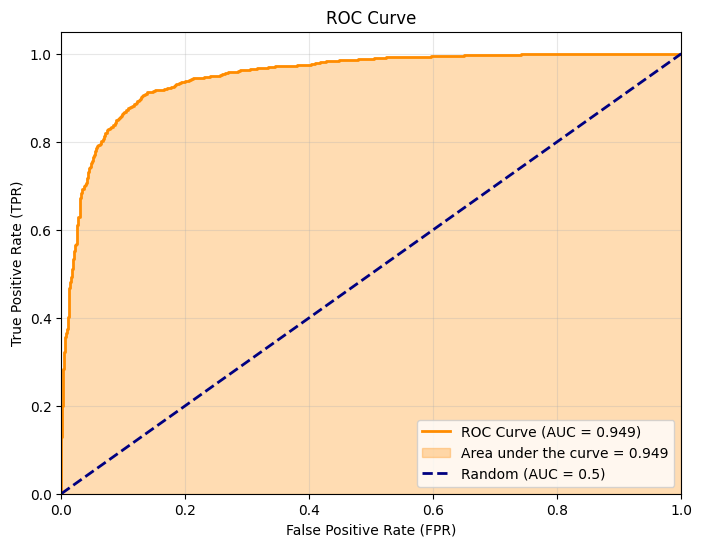

In [25]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

net.eval()
positive_similarities = []
negative_similarities = []

with torch.no_grad():
    for batch_idx, (anc, pos, neg) in enumerate(val_loader):
        anc, pos, neg = anc.to(device), pos.to(device), neg.to(device)
        anc_feat, pos_feat, neg_feat = net(anc), net(pos), net(neg)
        
        batch_pos_sim = F.cosine_similarity(anc_feat, pos_feat, dim=1)
        batch_neg_sim = F.cosine_similarity(anc_feat, neg_feat, dim=1)
        positive_similarities.append(batch_pos_sim)
        negative_similarities.append(batch_neg_sim)

positive_similarities = torch.cat(positive_similarities, dim=0)
negative_similarities = torch.cat(negative_similarities, dim=0)

scores = torch.cat([positive_similarities, negative_similarities], dim=0).cpu().numpy()
targets = torch.cat([
    torch.ones_like(positive_similarities),
    torch.zeros_like(negative_similarities)
], dim=0).cpu().numpy()

fpr, tpr, thresholds = roc_curve(targets, scores)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC Curve (AUC = {roc_auc:.3f})')
plt.fill_between(fpr, tpr, alpha=0.3, color='darkorange', label=f'Area under the curve = {roc_auc:.3f}')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random (AUC = 0.5)')
plt.xlim([0.0, 1.0])
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.grid(alpha=0.3)
plt.show()


Here, we add code to reload the model in case something goes wrong later in the notebook.


In [23]:
# save_dir = Path("runs/20251213_224845")
# net.load_state_dict(torch.load(save_dir / 'best_epoch_2.pth'))


# Distance Matrix

We can already compare the distances between `anchor` and `positive`, and those between `anchor` and `negative`. The former should be **smaller** than the latter.

One way to verify this is to construct a 10×10 matrix where each cell `(i, j)` contains the average distance (here derived from cosine similarity) between the embeddings of images from class \(i\) and those from class \(j\). On the diagonal, we find the intra-class distances (which should be small if the model groups similar images well). A *heatmap* allows quick visualization of the quality of the learned separation.

To calculate this matrix, we start by building a dictionary containing the embeddings from the validation set, grouped by class.


In [26]:
net.eval()

embeddings_by_class = {i: [] for i in range(10)} 

with torch.no_grad():
    anchor_labels = val_labels[:, 0]
    
    for idx in range(len(val_triplets)):
        label = int(anchor_labels[idx])
        
        img = torch.from_numpy(val_triplets[idx, 0].transpose(2, 0, 1) / 255.0).float()
        img = val_transforms(img)
        img = img.unsqueeze(0).to(device)
        
        embedding = net(img)
        embeddings_by_class[label].append(embedding.cpu())

embeddings_by_class = {label: torch.cat(embeddings_by_class[label], dim=0) for label in range(10)}
samples_per_class = [len(embeddings_by_class[i]) for i in range(10)]

print("Number of embeddings per class:")
for class_idx, count in enumerate(samples_per_class):
    print(f"  {label_names[class_idx]:10s} : {count}")


Number of embeddings per class:
  airplane   : 124
  automobile : 113
  bird       : 125
  cat        : 119
  deer       : 127
  dog        : 138
  frog       : 119
  horse      : 123
  ship       : 130
  truck      : 132


Now we can plot the heatmap distance matrix.

Dimension of the distance matrix: (10, 10)
Heatmap saved in runs/20251219_130352/distance_matrix_heatmap.png


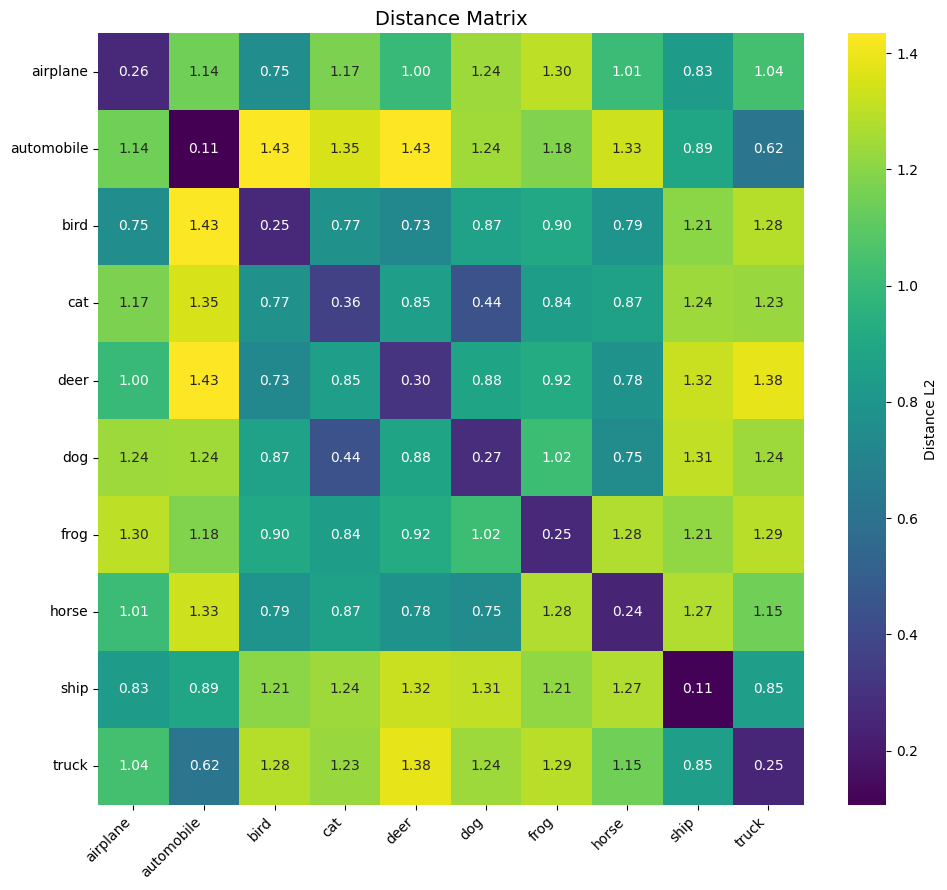


Intra-class distance: mean=0.2415, std=0.0742
Inter-class distance: mean=1.0587, std=0.2433
Separation margin: 0.8172


In [43]:
import seaborn as sns
dist_matrix = np.zeros((10, 10))

for i in range(10):
    for j in range(10):
        emb_i = embeddings_by_class[i]
        emb_j = embeddings_by_class[j]
        
        emb_i_norm = F.normalize(emb_i, p=2, dim=1)
        emb_j_norm = F.normalize(emb_j, p=2, dim=1)
        
        cosine_sim = torch.mm(emb_i_norm, emb_j_norm.t())
        cosine_dist = 1 - cosine_sim
        
        dist_matrix[i, j] = cosine_dist.mean().item()

print(f"Dimension of the distance matrix: {dist_matrix.shape}")

plt.figure(figsize=(10, 9))

col_labels = [f"{label_names[i]}" for i in range(10)]
row_labels = [f"{label_names[i]}" for i in range(10)]

sns.heatmap(dist_matrix, 
            xticklabels=col_labels, 
            yticklabels=row_labels,
            annot=True,
            fmt='.2f',
            cmap='viridis', 
            cbar_kws={'label': 'Distance L2'})

plt.title('Distance Matrix', fontsize=14)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()

plot_filename = save_dir / "distance_matrix_heatmap.png"
plt.savefig(plot_filename)
print(f"Heatmap saved in {plot_filename}")

plt.show()
plt.close()

same_class_dists = np.diag(dist_matrix)
diff_class_dists = []
for i in range(10):
    for j in range(10):
        if i != j:
            diff_class_dists.append(dist_matrix[i, j])

print(f"\nIntra-class distance: mean={np.mean(same_class_dists):.4f}, std={np.std(same_class_dists):.4f}")
print(f"Inter-class distance: mean={np.mean(diff_class_dists):.4f}, std={np.std(diff_class_dists):.4f}")
print(f"Separation margin: {np.mean(diff_class_dists) - np.mean(same_class_dists):.4f}")

Several interesting observations emerge from this matrix:

**Low diagonal**: intra-class distances (on the diagonal) are all less than 0.4, showing that the model groups images of the same class well. The best grouped classes are *ship* (0.11) and *airplane* (0.16).

**Good overall separation**: the separation margin (difference between the average inter-class distance and the average intra-class distance) is about 0.80, which is a good sign.

**Expected semantic confusions**: some pairs of classes remain relatively close, which corresponds to real visual similarities:
- *cat* and *dog* (0.36): two furry animals of similar size;
- *airplane* and *ship* (0.75): vehicles with elongated shapes, often with uniform backgrounds (sky/water);
- *automobile* and *truck* (0.66): road vehicles sharing common visual characteristics.

**Well-separated classes**: conversely, *automobile* vs *deer* (1.42) or *bird* vs *truck* (1.20) show high distances, consistent with the absence of visual resemblance between these categories.

## Principal Component Analysis

It is also interesting to observe how our embeddings are distributed. As they live in a 128-dimensional space, we project them into 2D to visualize them.

For this, we use PCA (Principal Component Analysis): a linear dimensionality reduction method.


In [44]:
from sklearn.decomposition import PCA

all_embeddings = torch.cat([embeddings_by_class[k] for k in embeddings_by_class], dim=0)

pca_2d = PCA(n_components=2)
embeddings_2d = pca_2d.fit_transform(all_embeddings)



We will normalize the embeddings. This ensures a fairer comparison with future results and makes the distances more interpretable.


In [45]:
embeddings_2d = (embeddings_2d - embeddings_2d.min(axis=0)) / (embeddings_2d.max(axis=0) - embeddings_2d.min(axis=0))

Let's proceed with the projection. In addition to the points, for each class, we draw an ellipse that contains \(k\%\) of the points (here k = 50%). We call this parameter `coverage`.

Let's start by writing the function that calculates the parameters of these ellipses. The calculation involves a Mahalanobis distance and an eigenvalue decomposition; I won't go into detail here, but I'll provide the code.


In [46]:
def compute_ellipse_parameters(embeddings, coverage):
    center = np.median(embeddings, axis=0)
    cov = np.cov(embeddings, rowvar=False)
    try:
        inv_cov = np.linalg.inv(cov)
    except np.linalg.LinAlgError:
        inv_cov = np.linalg.pinv(cov)

    # Squared Mahalanobis distances and empirical quantile for coverage
    d2 = np.einsum("ij,jk,ik->i", embeddings - center, inv_cov, embeddings - center)
    threshold = np.quantile(d2, coverage)

    # Ellipse parameters from covariance eigen decomposition
    vals, vecs = np.linalg.eigh(cov)
    order = vals.argsort()[::-1]
    vals, vecs = vals[order], vecs[:, order]
    width, height = 2.0 * np.sqrt(vals * threshold)
    angle = np.degrees(np.arctan2(vecs[1, 0], vecs[0, 0]))

    return center, width, height, angle


We can now calculate the ellipse parameters for each class.


In [47]:
labels_array = np.concatenate([np.full(count, label) for label, count in enumerate(samples_per_class)])

coverage = 0.50

def get_ellipse_params_per_class(embeddings_2d, coverage):
    ellipse_params = {}
    for cls in label_names:
        cls_idx = label_names.index(cls)
        X = embeddings_2d[labels_array == cls_idx]
        center, width, height, angle = compute_ellipse_parameters(X, coverage)
        ellipse_params[cls] = {
            "center": center.tolist(),
            "width": float(width),
            "height": float(height),
            "angle": float(angle),
        }
    return ellipse_params

ellipse_params = get_ellipse_params_per_class(embeddings_2d, coverage)


Let's proceed with the projection.


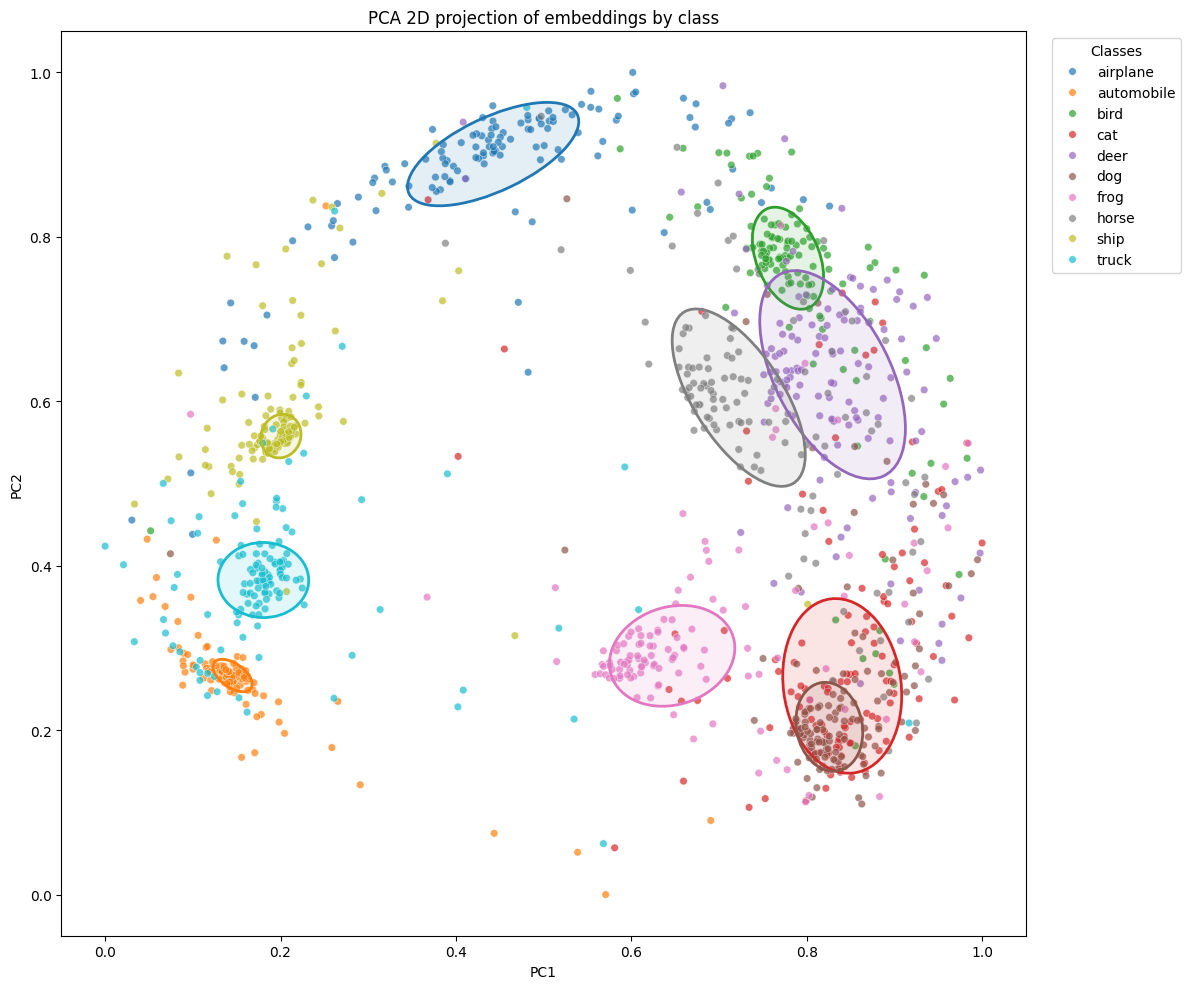

In [48]:
import pandas as pd
from matplotlib.patches import Ellipse

def plot_embeddings_with_ellipses(
    embeddings_2d,
    ellipse_params,
    save_img_path,
):
    pca_2d_df = pd.DataFrame({
        'PC1': embeddings_2d[:, 0],
        'PC2': embeddings_2d[:, 1],
        'Label': labels_array,
        'Class': [label_names[int(label)] for label in labels_array]
    })

    fig, ax = plt.subplots(figsize=(12, 10))
    
    palette = sns.color_palette("tab10", n_colors=10)
    class_names = sorted(pca_2d_df['Class'].unique())
    color_map = {cls: palette[i] for i, cls in enumerate(class_names)}

    sns.scatterplot(
        data=pca_2d_df, x='PC1', y='PC2',
        hue='Class', palette=color_map,
        alpha=0.7, s=30, ax=ax
    )

    for cls in class_names:
        ep = ellipse_params[cls]
        center, w, h, angle = ep["center"], ep["width"], ep["height"], ep["angle"]
        color = color_map[cls]
        
        ellipse = Ellipse(
            xy=center, width=w, height=h, angle=angle,
            facecolor=(*color, 0.12), edgecolor=color, linewidth=2
        )
        ax.add_patch(ellipse)

    ax.set_xlabel('PC1')
    ax.set_ylabel('PC2')
    ax.set_title('PCA 2D projection of embeddings by class')
    ax.legend(title='Classes', bbox_to_anchor=(1.02, 1), loc='upper left')
    
    plt.tight_layout()
    plt.savefig(save_img_path, dpi=150, bbox_inches='tight')
    plt.show()


plot_embeddings_with_ellipses(
    embeddings_2d,
    ellipse_params,
    save_img_path = save_dir / "embeddings_2d.png"
)


The result depends on the chosen `seed`. Unless you run the exact same code (and with the same `seed`), you will necessarily get a different projection. Nevertheless, we generally find a few trends:
- *ship* and *airplane* have the smallest ellipse areas, which confirms the analysis of the distance matrix
- the *cat* and *dog* points are close, as expected
- further confirmation from the distance matrix: *automobile* and *deer* are well separated, as are *bird* and *truck*.

Here are some statistics about our ellipse areas.


In [49]:
mean_area = 0
for ep_dict in ellipse_params.values():
    area = np.pi * ep_dict["width"] * ep_dict["height"]
    ep_dict["area"] = area
    mean_area += area

print(f"Average area of the ellipses: {mean_area / len(ellipse_params):.4f}")
for k, v in ellipse_params.items():
    if k in ["ship", "cat", "dog", "horse"]:
        print(f"Ellipse area of {k} = {v['area']:.4f}")

Average area of the ellipses: 0.0494
Ellipse area of cat = 0.0900
Ellipse area of dog = 0.0257
Ellipse area of horse = 0.0789
Ellipse area of ship = 0.0076


# Conclusion

In this article, we analyzed the embeddings obtained after training a Siamese network with a *triplet loss* on CIFAR‑10. The results show a good separation of classes in the embedding space, and the observed confusions (*cat*/*dog*, *airplane*/*ship*) correspond to real visual similarities. The distance matrix and the PCA projection (PCA) with confidence ellipses allow us to visualize and quantify the compactness of each group.

In the next part of this series, we will introduce the *KoLeo loss* to encourage a more uniform distribution of embeddings, and we will study the impact of gradient accumulation on this batch-dependent regularization.
